In [1]:
import json
import math
import multiprocessing
import os
import sys
from __future__ import division


import cv2
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import SimpleITK as sitk
# import tomopy
# from astropy.convolution import Gaussian2DKernel, interpolate_replace_nans
from PIL import Image
from scipy import interpolate
from scipy.ndimage import median_filter
from scipy.signal import medfilt2d
from skimage.registration import phase_cross_correlation
from tqdm import trange, tqdm
from typing import List
import SimpleITK as sitk
import datetime

import tigre
import tigre.algorithms as algs
from tigre.utilities.geometry import Geometry

import shared_functions as s

drive = 'f:\\'
base_folder = os.path.join(drive, 'jasper', 'data', '20221024_THscan_keV_Repeat')

base_json_file = os.path.join(base_folder, 'scan_settings.json')
results_folder = os.path.join(base_folder, 'results')
if not os.path.exists(results_folder):
    os.makedirs(results_folder)

gReconParams = dict()
gReconParams['pixels'] = 512  # (pixels)
gReconParams['pixel_pitch'] = 0.055  # (mm)
gReconParams['fill_gap'] = True
gReconParams['median_filter'] = False
gReconParams['bad_pixel_correction'] = True
gReconParams['recon_voxels'] = (
    gReconParams['pixels'], gReconParams['pixels'], gReconParams['pixels'])  # number of voxels (vx)
 
gReconParams['distance_source_detector'] = 197.59
gReconParams['z_stage_distance_mm'] = s.get_sample_z_from_first_scan_json(base_json_file) # Varies between 0 and 100 mm
gReconParams['distance_object_detector'] = 30 + \
    gReconParams['z_stage_distance_mm'] + 9+9+0.055+1.035  # (mm)
gReconParams['detector_rotation'] = (math.radians(0.), 0., 0.)  # (mm)

assert gReconParams['z_stage_distance_mm'] < 100 and gReconParams['z_stage_distance_mm'] >= 0


DSD = gReconParams['distance_source_detector']
DSO = DSD - gReconParams['distance_object_detector']
a = gReconParams['pixels'] * gReconParams['pixel_pitch'] / (((DSD-DSO) / DSO) + 1)
gReconParams['recon_size'] = (a, a, a)



In [2]:
spectral_projs_th0, spectral_open_th0, spectral_projs_th1, spectral_open_th1, th0_list, th1_list, exp_time, angles, z_offset, detector_x_offsets, detector_y_offsets, th0_dacs_list, th1_dacs_list = \
    s.load_or_generate_data_arrays(base_json_file, base_folder, results_folder, gReconParams)

Making new numpy files, should take ~4.5 minutes. At least one file was missing :( 


100%|██████████| 35/35 [00:00<00:00, 8743.86it/s]


['f:\\jasper\\data\\20221014_THscan_keV\\000_5.0_5.0', 'f:\\jasper\\data\\20221014_THscan_keV\\001_5.5_5.5', 'f:\\jasper\\data\\20221014_THscan_keV\\002_6.0_6.0', 'f:\\jasper\\data\\20221014_THscan_keV\\003_6.5_6.5', 'f:\\jasper\\data\\20221014_THscan_keV\\004_7.0_7.0', 'f:\\jasper\\data\\20221014_THscan_keV\\005_7.5_7.5', 'f:\\jasper\\data\\20221014_THscan_keV\\006_8.0_8.0', 'f:\\jasper\\data\\20221014_THscan_keV\\007_8.5_8.5', 'f:\\jasper\\data\\20221014_THscan_keV\\008_9.0_9.0', 'f:\\jasper\\data\\20221014_THscan_keV\\009_9.5_9.5', 'f:\\jasper\\data\\20221014_THscan_keV\\010_10.0_10.0', 'f:\\jasper\\data\\20221014_THscan_keV\\011_10.5_10.5', 'f:\\jasper\\data\\20221014_THscan_keV\\012_11.0_11.0', 'f:\\jasper\\data\\20221014_THscan_keV\\013_11.5_11.5', 'f:\\jasper\\data\\20221014_THscan_keV\\014_12.0_12.0', 'f:\\jasper\\data\\20221014_THscan_keV\\015_12.5_12.5', 'f:\\jasper\\data\\20221014_THscan_keV\\016_13.0_13.0', 'f:\\jasper\\data\\20221014_THscan_keV\\017_13.5_13.5', 'f:\\jasper

100%|██████████| 35/35 [05:07<00:00,  8.78s/it]


In [3]:
spectral_projs_th0 = spectral_projs_th0[:,0,:,:]
spectral_projs_th1 = spectral_projs_th1[:,0,:,:]

mean_th0_0 = np.median(spectral_projs_th0[:,0:253,0:253], axis=(1,2))
mean_th0_1 = np.median(spectral_projs_th0[:,0:253,257:], axis=(1,2))
mean_th0_2 = np.median(spectral_projs_th0[:,257:,257:], axis=(1,2))
mean_th0_3 = np.median(spectral_projs_th0[:,257:,0:253], axis=(1,2))

mean_th1_0 = np.median(spectral_projs_th1[:,0:253,0:253], axis=(1,2))
mean_th1_1 = np.median(spectral_projs_th1[:,0:253,257:], axis=(1,2))
mean_th1_2 = np.median(spectral_projs_th1[:,257:,257:], axis=(1,2))
mean_th1_3 = np.median(spectral_projs_th1[:,257:,0:253], axis=(1,2))


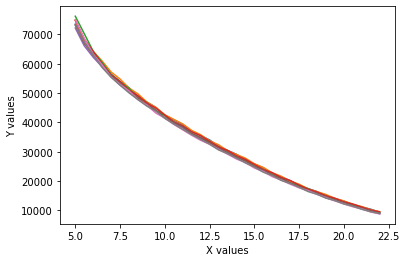

In [5]:
plt.xlabel('X values')
plt.ylabel('Y values')
plt.plot(th0_list, mean_th0_0)
plt.plot(th0_list, mean_th0_1)
plt.plot(th0_list, mean_th0_2)
plt.plot(th0_list, mean_th0_3)

# plt.show()

# plt.xlabel('X values')
# plt.ylabel('Y values')
plt.plot(th1_list, mean_th1_0)
plt.plot(th1_list, mean_th1_1)
plt.plot(th1_list, mean_th1_2)
plt.plot(th1_list, mean_th1_3)

plt.show()

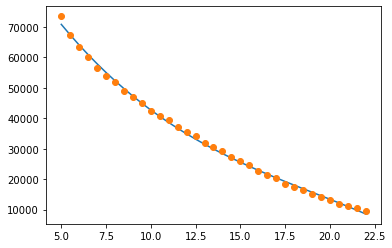

In [8]:
poly_coeffs, _, _, _, _ = np.polyfit(th0_list, mean_th0_0, 3, full=True)
yn = np.poly1d(poly_coeffs)
plt.plot( th0_list,yn(th0_list),th0_list,mean_th0_0,'o')

In [13]:
thresh = np.linspace(5.0,25,51,True)
# print(thresh)
# print(yn(thresh[0]))
cnts = yn(thresh)
cnts = cnts/cnts[0]
exptime = 0.2/cnts
print(exptime)
print(poly_coeffs)

[ 0.2         0.20821243  0.21677805  0.22571008  0.23502216  0.24472829
  0.25484297  0.26538122  0.27635872  0.2877919   0.29969818  0.31209608
  0.32500556  0.3384483   0.35244812  0.36703143  0.3822278   0.39807071
  0.41459833  0.43185456  0.44989021  0.46876454  0.48854693  0.50931909
  0.53117766  0.5542374   0.5786352   0.60453497  0.63213398  0.6616707
  0.69343516  0.72778228  0.76514965  0.80608139  0.85126083  0.901556
  0.95808432  1.02230669  1.09616786  1.18231215  1.28442621  1.40780578
  1.56033832  1.75430647  2.00994251  2.36309952  2.88393203  3.73081623
  5.35262958  9.71899592 62.40868946]
[-7.97259939e+00  4.58451842e+02 -1.11047421e+04  1.15884991e+05]


In [ ]:

th0_0_keV = (th0_list* 0.214) + -1.700
th0_1_keV = (th0_list* 0.205) + -1.762
th0_2_keV = (th0_list* 0.207) + -1.439
th0_3_keV = (th0_list* 0.217) + -1.577

th1_0_keV = (th0_list* 0.222) + -1.292
th1_1_keV = (th0_list* 0.214) + -1.123
th1_2_keV = (th0_list* 0.216) + -1.258
th1_3_keV = (th0_list* 0.222) + -1.210


plt.xlabel('X values')
plt.ylabel('Y values')
plt.scatter(th0_0_keV, mean_th0_0)
plt.scatter(th0_1_keV, mean_th0_1)
plt.scatter(th0_2_keV, mean_th0_2)
plt.scatter(th0_3_keV, mean_th0_3)
# plt.show()

# plt.xlabel('X values')
# plt.ylabel('Y values')
plt.scatter(th1_0_keV, mean_th1_0)
plt.scatter(th1_1_keV, mean_th1_1)
plt.scatter(th1_2_keV, mean_th1_2)
plt.scatter(th1_3_keV, mean_th1_3)
plt.show()

# th0_1_keV = (th0_list + -1.762)* 0.205
# plt.scatter(th0_1_keV, mean_th0_1)
# plt.scatter(th0_3_keV, mean_th0_3)


In [ ]:
th_levels = np.linspace(5.5,19, 28,True)
print(th_levels)


# chip0 = (th_levels - -1.700)/0.214
# chip1 = (th_levels - -0.6)/0.193
# chip2 = (th_levels - -1.2)/0.205
# chip3 = (th_levels - -0.1)/0.205

chip0 = (th_levels - -1.700)/0.214
chip1 = (th_levels - -0.63)/0.193
chip2 = (th_levels - -1.18)/0.205
chip3 = (th_levels - -0.04)/0.204


indices0 =np.rint(chip0).astype(int)-25
indices1 =np.rint(chip1).astype(int)-25
indices2 =np.rint(chip2).astype(int)-25
indices3 =np.rint(chip3).astype(int)-25

values0 = np.take(mean_th0_0, indices0)
values1 = np.take(mean_th0_1, indices1)
values2 = np.take(mean_th0_2, indices2)
values3 = np.take(mean_th0_3, indices3)

print(np.sqrt(np.mean(np.square(values1-values0))))
print(np.sqrt(np.mean(np.square(values2-values0))))
print(np.sqrt(np.mean(np.square(values3-values0))))

print(indices3)
plt.xlabel('X values')
plt.ylabel('Y values')
plt.scatter(th_levels, values0)
plt.scatter(th_levels, values1)
plt.scatter(th_levels, values2)
plt.scatter(th_levels, values3)
# plt.scatter(th0_1_keV, mean_th0_1)



In [ ]:
th_levels = np.linspace(5.5,19, 28,True)
chip0 = (th_levels - -1.700)/0.214
indices0 =np.rint(chip0).astype(int)-25
values0 = np.take(mean_th0_0, indices0)

th0_0_a = 0.214
th0_0_b = -1.700


chip1_a = 0.205
chip1_b = -1.18
best_rms = 9999999
best_a = 0
best_b = 0

for i in range(-20, 20):
    for j in range(-100,110):
        a = chip1_a + (i/1000)
        b = chip1_b + (j/100)
        chip1 = (th_levels - b)/a
        indices1 =np.rint(chip1).astype(int)-25
        # print(indices1)
        values1 = np.take(mean_th0_1, indices1)
        rms = np.sqrt(np.mean(np.square(values1-values0)))
        # print(a, b, rms, sep='\t')
        if rms<best_rms:
            best_rms=rms
            best_a = a
            best_b = b
print('best for chip1_th0', best_a, best_b, best_rms, sep='\t')
th0_1_a = best_a
th0_1_b = best_b

# chip2 = (th_levels - -1.2)/0.205
chip2_a = 0.204
chip2_b = -0.04
best_rms = 9999999
best_a = 0
best_b = 0
for i in range(-20, 20):
    for j in range(-100,110):
        a = chip2_a + (i/1000)
        b = chip2_b + (j/100)
        chip2 = (th_levels - b)/a
        indices2 =np.rint(chip2).astype(int)-25
        # print(indices1)
        values2 = np.take(mean_th0_2, indices2)
        rms = np.sqrt(np.mean(np.square(values2-values0)))
        # print(a, b, rms, sep='\t')
        if rms<best_rms:
            best_rms=rms
            best_a = a
            best_b = b
print('best for chip2_th0', best_a, best_b, best_rms, sep='\t')
th0_2_a = best_a
th0_2_b = best_b

# /chip3 = (th_levels - -0.1)/0.205
chip3_a = 0.193
chip3_b = -0.63
best_rms = 9999999
best_a = 0
best_b = 0
for i in range(-20, 20):
    for j in range(-100,110):
        a = chip3_a + (i/1000)
        b = chip3_b + (j/100)
        chip3 = (th_levels - b)/a
        indices3 =np.rint(chip3).astype(int)-25
        # print(indices1)
        values3 = np.take(mean_th0_3, indices3)
        rms = np.sqrt(np.mean(np.square(values3-values0)))
        # print(a, b, rms, sep='\t')
        if rms<best_rms:
            best_rms=rms
            best_a = a
            best_b = b
print('best for chip3_th0', best_a, best_b, best_rms, sep='\t')
th0_3_a = best_a
th0_3_b = best_b

#now check chip0 th1
 
chip0_a = 0.225
chip0_b = -1.412
best_rms = 9999999
best_a = 0
best_b = 0

for i in range(-20, 20):
    for j in range(-100,110):
        a = chip0_a + (i/1000)
        b = chip0_b + (j/100)
        chip0 = (th_levels - b)/a
        indices0 =np.rint(chip0).astype(int)-25
        # print(indices1)
        values0_th1 = np.take(mean_th1_0, indices0)
        rms = np.sqrt(np.mean(np.square(values0_th1-values0)))
        # print(a, b, rms, sep='\t')
        if rms<best_rms:
            best_rms=rms
            best_a = a
            best_b = b
print('best for chip0_th1', best_a, best_b, best_rms, sep='\t')
th1_0_a = best_a
th1_0_b = best_b


#now check chip1 th1

chip1_a = 0.214
chip1_b = -1.073
best_rms = 9999999
best_a = 0
best_b = 0

for i in range(-20, 20):
    for j in range(-100,110):
        a = chip1_a + (i/1000)
        b = chip1_b + (j/100)
        chip1 = (th_levels - b)/a
        indices1 =np.rint(chip1).astype(int)-25
        # print(indices1)
        values1 = np.take(mean_th1_1, indices1)
        rms = np.sqrt(np.mean(np.square(values1-values0)))
        # print(a, b, rms, sep='\t')
        if rms<best_rms:
            best_rms=rms
            best_a = a
            best_b = b
print('best for chip1_th1', best_a, best_b, best_rms, sep='\t')
th1_1_a = best_a
th1_1_b = best_b
#now check chip2 th1

chip2_a = 0.210
chip2_b = 0.132
best_rms = 9999999
best_a = 0
best_b = 0

for i in range(-20, 20):
    for j in range(-100,110):
        a = chip2_a + (i/1000)
        b = chip2_b + (j/100)
        chip2 = (th_levels - b)/a
        indices2 =np.rint(chip2).astype(int)-25
        # print(indices1)
        values2 = np.take(mean_th1_2, indices2)
        rms = np.sqrt(np.mean(np.square(values2-values0)))
        # print(a, b, rms, sep='\t')
        if rms<best_rms:
            best_rms=rms
            best_a = a
            best_b = b
print('best for chip2_th1', best_a, best_b, best_rms, sep='\t')
th1_2_a = best_a
th1_2_b = best_b
#now check chip3 th1

chip3_a = 0.205
chip3_b = -0.23
best_rms = 9999999
best_a = 0
best_b = 0

for i in range(-20, 20):
    for j in range(-100,110):
        a = chip3_a + (i/1000)
        b = chip3_b + (j/100)
        chip3 = (th_levels - b)/a
        indices3 =np.rint(chip3).astype(int)-25
        # print(indices1)
        values3 = np.take(mean_th1_3, indices3)
        rms = np.sqrt(np.mean(np.square(values3-values0)))
        # print(a, b, rms, sep='\t')
        if rms<best_rms:
            best_rms=rms
            best_a = a
            best_b = b
print('best for chip3_th1', best_a, best_b, best_rms, sep='\t')
th1_3_a = best_a
th1_3_b = best_b


In [ ]:

th0_0_keV = (th0_list* th0_0_a) + th0_0_b
th0_1_keV = (th0_list* th0_1_a) + th0_1_b
th0_2_keV = (th0_list* th0_2_a) + th0_2_b
th0_3_keV = (th0_list* th0_3_a) + th0_3_b

th1_0_keV = (th1_list* th1_0_a) + th1_0_b
th1_1_keV = (th1_list* th1_1_a) + th1_1_b
th1_2_keV = (th1_list* th1_2_a) + th1_2_b
th1_3_keV = (th1_list* th1_3_a) + th1_3_b


plt.xlabel('X values')
plt.ylabel('Y values')
plt.scatter(th0_0_keV, mean_th0_0)
plt.scatter(th0_1_keV, mean_th0_1)
plt.scatter(th0_2_keV, mean_th0_2)
plt.scatter(th0_3_keV, mean_th0_3)
# plt.show()

# plt.xlabel('X values')
# plt.ylabel('Y values')
plt.scatter(th1_0_keV, mean_th1_0)
plt.scatter(th1_1_keV, mean_th1_1)
plt.scatter(th1_2_keV, mean_th1_2)
plt.scatter(th1_3_keV, mean_th1_3)
plt.show()


In [ ]:
print(th0_1_keV)